# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [8]:
train[target_name].mean()

0.19044

In [9]:
train[target_name][train.DepTime > 2400].mean()

1.0

In [10]:
train[target_name][train.DepTime > 2400].shape

(17,)

In [11]:
train.shape

(100000, 9)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [13]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [14]:
test.shape

(100000, 8)

## Split Data

In [15]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## Exploration

<AxesSubplot:>

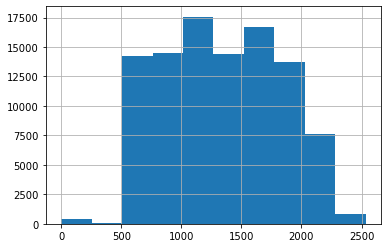

In [17]:
train.DepTime.hist()

In [18]:
train.DepTime.min(), train.DepTime.max()

(1, 2534)

In [19]:
time_groups = train.groupby((train.DepTime-1) // 100) 

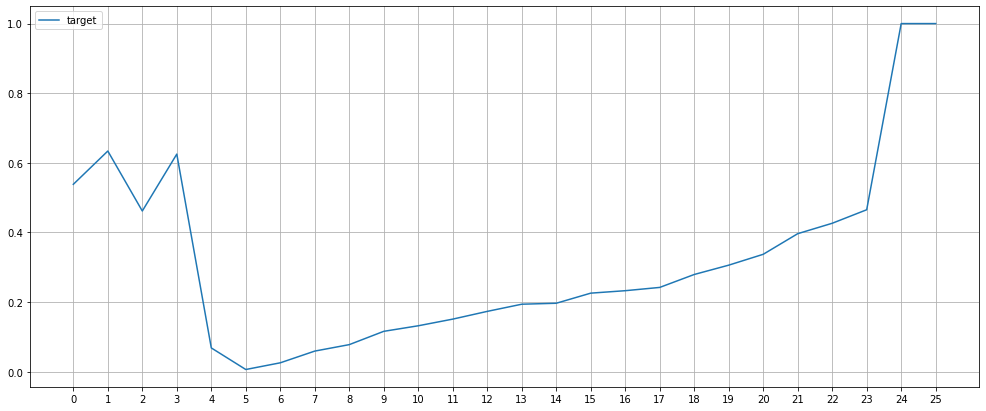

In [20]:
mean_by_t = time_groups[target_name].mean()
count_by_t = time_groups[target_name].count()

plt.figure(figsize=(17, 7))

plt.plot(mean_by_t.index, mean_by_t, label='target')
plt.xticks(range(0, 26))
plt.grid()
plt.legend()

## timestamp decoding

In [21]:
def get_ts(df):
    df['hour'] = df.DepTime // 100
    df['minute'] = df.DepTime % 100
    df['d_month'] = df.DayofMonth.str[2:].astype(int)
    df['d_week'] = df.DayOfWeek.str[2:].astype(int)
    df['month'] = df.Month.str[2:].astype(int)
    
    return df

## Category encoding

In [22]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [23]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [24]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [25]:
%%time
enc.fit(X_train[cat_cols])

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 168 ms, sys: 18.5 ms, total: 186 ms
Wall time: 270 ms


OrdinalEncoder(cols=Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object'),
               handle_missing='return_nan', handle_unknown='return_nan',
               mapping=[{'col': 'Month', 'data_type': dtype('O'),
                         'mapping': c-8      1
c-2      2
c-10     3
c-4      4
c-11     5
c-7      6
c-1      7
c-5      8
c-6      9
c-12    10
c-3     11
c-9     12
NaN     -2
dtype: int64},
                        {'col': 'DayofMonth', 'data_type': dtype('O'),
                         'mapping': c-2...
                         'mapping': AA      1
US      2
CO      3
YV      4
WN      5
NW      6
FL      7
DL      8
OH      9
OO     10
MQ     11
UA     12
XE     13
EV     14
HA     15
B6     16
HP     17
F9     18
AS     19
DH     20
AQ     21
TZ     22
NaN    -2
dtype: int64},
                        {'col': 'Origin', 'data_type': dtype('O'),
                         'mapping': DFW      1
DCA      2
BOS      3
MCI      4
MDT      

## Sin/cos ts processing

In [26]:
t_limits = {'minute': (0, 59),
             'hour': (0, 23),
             'd_week': (1, 7),
             'd_month': (1, 31),
             'month': (1, 12)}

In [27]:
def sin_cos(df):
    for col_name, limits in t_limits.items():
        max_val = limits[1]
        min_val = limits[0]
        if col_name == 'hour':
            orig_vals = df[col_name].clip(upper=max_val)
        else:
            orig_vals = df[col_name]
        df[col_name + '_sin'] = np.sin(2*np.pi/(max_val - min_val)*orig_vals)
        df[col_name + '_cos'] = np.cos(2*np.pi/(max_val - min_val)*orig_vals)
        
    return df

## Sum up prepocessing

In [28]:
def preproc(df):
    df = get_ts(df)
    df = sin_cos(df)
    
    df[cat_cols] = enc.transform(df[cat_cols])
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Special features
    df['after_midnight'] = 0
    df.loc[df.DepTime > 2401, 'after_midnight'] = 1
    
    return df

In [29]:
%%time
X_train = preproc(X_train)
X_test = preproc(X_test)

<ipython-input-21-0555f0c157ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.DepTime // 100
<ipython-input-21-0555f0c157ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df.DepTime % 100
<ipython-input-21-0555f0c157ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

CPU times: user 523 ms, sys: 88.8 ms, total: 612 ms
Wall time: 890 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


# Fit

In [51]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,hour,minute,...,minute_cos,hour_sin,hour_cos,d_week_sin,d_week_cos,d_month_sin,d_month_cos,month_sin,month_cos,after_midnight
46343,1.0,1.0,1.0,1805,1.0,1.0,1.0,1235,18,5,...,0.861554,-0.979084,0.203456,8.660254e-01,0.5,-9.945219e-01,-0.104528,-9.898214e-01,-0.142315,0
75701,2.0,2.0,2.0,819,2.0,2.0,2.0,892,8,19,...,-0.437307,0.816970,-0.576680,1.224647e-16,-1.0,1.224647e-16,-1.000000,9.096320e-01,0.415415,0
89227,3.0,3.0,2.0,726,3.0,3.0,3.0,200,7,26,...,-0.931336,0.942261,-0.334880,1.224647e-16,-1.0,-5.877853e-01,-0.809017,-5.406408e-01,0.841254,0
70825,4.0,4.0,3.0,1515,1.0,4.0,4.0,403,15,15,...,-0.026621,-0.816970,-0.576680,8.660254e-01,0.5,8.660254e-01,-0.500000,7.557496e-01,-0.654861,0
26022,5.0,5.0,4.0,1453,4.0,5.0,5.0,94,14,53,...,0.802712,-0.631088,-0.775711,-8.660254e-01,0.5,-9.510565e-01,0.309017,-2.449294e-16,1.000000,0


In [30]:
model = lgb.LGBMClassifier()

In [31]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_fraction': 0.8,
               'bagging_freq': 10,
               'feature_fraction': 0.8,
               'learning_rate': 0.1,
               'max_depth': 10,
               'min_data_in_leaf': int(0.01*len(X_train)),
               'n_jobs': 8,
#                'num_leaves': 10,
               'n_estimators': 10_000,
               'reg_alpha': 5,
               'reg_lambda': 5,
               'random_state': RANDOM_STATE}

In [32]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

In [33]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [34]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's auc: 0.714705	training's binary_logloss: 0.48012	valid_1's auc: 0.700418	valid_1's binary_logloss: 0.478008
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.720533	training's binary_logloss: 0.473839	valid_1's auc: 0.712617	valid_1's binary_logloss: 0.471648
[3]	training's auc: 0.72785	training's binary_logloss: 0.467306	valid_1's auc: 0.712117	valid_1's binary_logloss: 0.466255
[4]	training's auc: 0.732994	training's binary_logloss: 0.46211	valid_1's auc: 0.714917	valid_1's binary_logloss: 0.461922
[5]	training's auc: 0.736506	training's binary_logloss: 0.457322	valid_1's auc: 0.717266	valid_1's binary_logloss: 0.457838
[6]	training's auc: 0.738647	training's binary_logloss: 0.453104	valid_1's auc: 0.717266	valid_1's binary_logloss: 0.454454
[7]	training's auc: 0.741519	training's binary_logloss: 0.449481	valid_1's auc: 0.718655	valid_1's binary_logloss: 0.451578
[8]	training's auc: 0.74347	training's binary_logloss: 0.446297	valid_1's

[74]	training's auc: 0.827721	training's binary_logloss: 0.381685	valid_1's auc: 0.729952	valid_1's binary_logloss: 0.430313
[75]	training's auc: 0.82875	training's binary_logloss: 0.381052	valid_1's auc: 0.729718	valid_1's binary_logloss: 0.43043
[76]	training's auc: 0.829439	training's binary_logloss: 0.38061	valid_1's auc: 0.729646	valid_1's binary_logloss: 0.43039
[77]	training's auc: 0.830295	training's binary_logloss: 0.380107	valid_1's auc: 0.729428	valid_1's binary_logloss: 0.430489
[78]	training's auc: 0.83079	training's binary_logloss: 0.379762	valid_1's auc: 0.72953	valid_1's binary_logloss: 0.430385
[79]	training's auc: 0.831499	training's binary_logloss: 0.379301	valid_1's auc: 0.729335	valid_1's binary_logloss: 0.430506
[80]	training's auc: 0.832198	training's binary_logloss: 0.378842	valid_1's auc: 0.729283	valid_1's binary_logloss: 0.430548
[81]	training's auc: 0.833201	training's binary_logloss: 0.378271	valid_1's auc: 0.72941	valid_1's binary_logloss: 0.430475
[82]	tr

[144]	training's auc: 0.871366	training's binary_logloss: 0.350257	valid_1's auc: 0.727655	valid_1's binary_logloss: 0.43172
[145]	training's auc: 0.871637	training's binary_logloss: 0.350004	valid_1's auc: 0.727533	valid_1's binary_logloss: 0.431764
[146]	training's auc: 0.87221	training's binary_logloss: 0.349576	valid_1's auc: 0.727479	valid_1's binary_logloss: 0.43181
[147]	training's auc: 0.872895	training's binary_logloss: 0.349174	valid_1's auc: 0.727484	valid_1's binary_logloss: 0.431787
[148]	training's auc: 0.873336	training's binary_logloss: 0.348866	valid_1's auc: 0.727502	valid_1's binary_logloss: 0.431794
[149]	training's auc: 0.873923	training's binary_logloss: 0.348449	valid_1's auc: 0.727497	valid_1's binary_logloss: 0.431778
[150]	training's auc: 0.874442	training's binary_logloss: 0.348111	valid_1's auc: 0.727438	valid_1's binary_logloss: 0.431809
[151]	training's auc: 0.874848	training's binary_logloss: 0.347843	valid_1's auc: 0.727577	valid_1's binary_logloss: 0.43

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

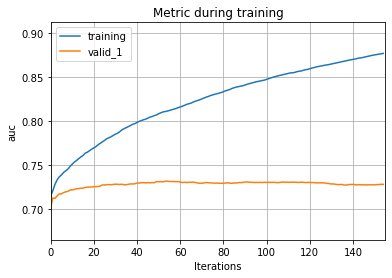

In [35]:
lgb.plot_metric(model, metric='auc')

In [36]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [37]:
with pd.option_context('display.max_rows', None):
    display(fi.sort_values(ascending=False))

Origin            458
Dest              405
DayofMonth        283
UniqueCarrier     108
Month             100
DepTime            55
hour_sin           50
hour_cos           39
DayOfWeek          25
Distance           24
d_week_sin         23
minute_cos         20
minute_sin         13
hour               12
month               9
month_sin           6
d_week              5
d_month_sin         5
minute              3
d_month             2
d_week_cos          2
d_month_cos         2
month_cos           1
after_midnight      0
dtype: int32

# Validate

In [38]:
def get_proba(X):
    proba = model.predict_proba(X)[:, 1]
#     proba[X.DepTime > 2400] = 1.
    return proba

In [39]:
tr_proba = get_proba(X_tr)

In [40]:
roc_auc_score(y_tr, get_proba(X_tr))

0.8111409130948728

In [41]:
roc_auc_score(y_train, get_proba(X_train))

0.803373532311901

In [42]:
roc_auc_score(y_test, get_proba(X_test))

0.7301736259107511

# Commit

## Refit on full dataset

In [43]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [44]:
enc.fit(X_train[cat_cols]);

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


OrdinalEncoder(cols=Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object'),
               handle_missing='return_nan', handle_unknown='return_nan',
               mapping=[{'col': 'Month',
                         'data_type': CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                  12.0],
                 ordered=False),
                         'mapping': 1.0      1
2.0      2
3.0      3
4.0      4
5.0      5
6.0      6
7.0      7
8.0      8
9.0      9
10.0    10
1...
2.0        2
3.0        3
4.0        4
5.0        5
        ... 
284.0    284
285.0    285
286.0    286
287.0    287
NaN       -2
Length: 288, dtype: int64},
                        {'col': 'Dest',
                         'data_type': CategoricalDtype(categories=[  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,
                    9.0,  10.0,
                  ...
                  280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 28

In [45]:
X = preproc(X)

In [46]:
X_tr, X_es, y_tr, y_es = train_test_split(X, y,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [47]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's auc: 0.698284	training's binary_logloss: 0.479124	valid_1's auc: 0.688931	valid_1's binary_logloss: 0.483156
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.703758	training's binary_logloss: 0.473092	valid_1's auc: 0.693563	valid_1's binary_logloss: 0.477362
[3]	training's auc: 0.705311	training's binary_logloss: 0.468505	valid_1's auc: 0.695364	valid_1's binary_logloss: 0.47299
[4]	training's auc: 0.706566	training's binary_logloss: 0.464237	valid_1's auc: 0.696451	valid_1's binary_logloss: 0.468963
[5]	training's auc: 0.707865	training's binary_logloss: 0.460741	valid_1's auc: 0.699591	valid_1's binary_logloss: 0.465509
[6]	training's auc: 0.708644	training's binary_logloss: 0.457707	valid_1's auc: 0.70021	valid_1's binary_logloss: 0.462711
[7]	training's auc: 0.709575	training's binary_logloss: 0.455118	valid_1's auc: 0.701453	valid_1's binary_logloss: 0.460263
[8]	training's auc: 0.710684	training's binary_logloss: 0.452864	valid_1

[71]	training's auc: 0.739357	training's binary_logloss: 0.427009	valid_1's auc: 0.720549	valid_1's binary_logloss: 0.43867
[72]	training's auc: 0.739622	training's binary_logloss: 0.426823	valid_1's auc: 0.720561	valid_1's binary_logloss: 0.438601
[73]	training's auc: 0.739934	training's binary_logloss: 0.426682	valid_1's auc: 0.720735	valid_1's binary_logloss: 0.438532
[74]	training's auc: 0.740163	training's binary_logloss: 0.426557	valid_1's auc: 0.720768	valid_1's binary_logloss: 0.438491
[75]	training's auc: 0.740369	training's binary_logloss: 0.426435	valid_1's auc: 0.720733	valid_1's binary_logloss: 0.438436
[76]	training's auc: 0.740611	training's binary_logloss: 0.426307	valid_1's auc: 0.720848	valid_1's binary_logloss: 0.438396
[77]	training's auc: 0.740894	training's binary_logloss: 0.426172	valid_1's auc: 0.720883	valid_1's binary_logloss: 0.438385
[78]	training's auc: 0.741115	training's binary_logloss: 0.42606	valid_1's auc: 0.720869	valid_1's binary_logloss: 0.438381
[7

[138]	training's auc: 0.753764	training's binary_logloss: 0.419334	valid_1's auc: 0.722571	valid_1's binary_logloss: 0.437086
[139]	training's auc: 0.753887	training's binary_logloss: 0.419262	valid_1's auc: 0.72259	valid_1's binary_logloss: 0.437073
[140]	training's auc: 0.754037	training's binary_logloss: 0.419178	valid_1's auc: 0.722644	valid_1's binary_logloss: 0.437056
[141]	training's auc: 0.754238	training's binary_logloss: 0.419091	valid_1's auc: 0.722725	valid_1's binary_logloss: 0.437018
[142]	training's auc: 0.754391	training's binary_logloss: 0.41901	valid_1's auc: 0.722722	valid_1's binary_logloss: 0.437022
[143]	training's auc: 0.754577	training's binary_logloss: 0.418926	valid_1's auc: 0.722777	valid_1's binary_logloss: 0.436996
[144]	training's auc: 0.754708	training's binary_logloss: 0.418857	valid_1's auc: 0.722841	valid_1's binary_logloss: 0.436962
[145]	training's auc: 0.754913	training's binary_logloss: 0.418749	valid_1's auc: 0.722898	valid_1's binary_logloss: 0.4

[206]	training's auc: 0.764485	training's binary_logloss: 0.41363	valid_1's auc: 0.723504	valid_1's binary_logloss: 0.436541
[207]	training's auc: 0.764591	training's binary_logloss: 0.413575	valid_1's auc: 0.723547	valid_1's binary_logloss: 0.43652
[208]	training's auc: 0.76471	training's binary_logloss: 0.413498	valid_1's auc: 0.723421	valid_1's binary_logloss: 0.436586
[209]	training's auc: 0.764843	training's binary_logloss: 0.413429	valid_1's auc: 0.723499	valid_1's binary_logloss: 0.436564
[210]	training's auc: 0.764946	training's binary_logloss: 0.413369	valid_1's auc: 0.72342	valid_1's binary_logloss: 0.436593
[211]	training's auc: 0.765122	training's binary_logloss: 0.413287	valid_1's auc: 0.72345	valid_1's binary_logloss: 0.436566
[212]	training's auc: 0.765279	training's binary_logloss: 0.413206	valid_1's auc: 0.72354	valid_1's binary_logloss: 0.436515
[213]	training's auc: 0.76546	training's binary_logloss: 0.41313	valid_1's auc: 0.723647	valid_1's binary_logloss: 0.436464


[273]	training's auc: 0.773069	training's binary_logloss: 0.408927	valid_1's auc: 0.722853	valid_1's binary_logloss: 0.436735
[274]	training's auc: 0.77323	training's binary_logloss: 0.408859	valid_1's auc: 0.72292	valid_1's binary_logloss: 0.436699
[275]	training's auc: 0.773394	training's binary_logloss: 0.408788	valid_1's auc: 0.723019	valid_1's binary_logloss: 0.436662
[276]	training's auc: 0.773526	training's binary_logloss: 0.408719	valid_1's auc: 0.72295	valid_1's binary_logloss: 0.436689
[277]	training's auc: 0.773717	training's binary_logloss: 0.408637	valid_1's auc: 0.722994	valid_1's binary_logloss: 0.436668
[278]	training's auc: 0.773829	training's binary_logloss: 0.408577	valid_1's auc: 0.722972	valid_1's binary_logloss: 0.436689
[279]	training's auc: 0.773955	training's binary_logloss: 0.408517	valid_1's auc: 0.723004	valid_1's binary_logloss: 0.436677
[280]	training's auc: 0.774081	training's binary_logloss: 0.408455	valid_1's auc: 0.723008	valid_1's binary_logloss: 0.43

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='gbdt',
               feature_fraction=0.8, max_depth=10, min_data_in_leaf=700,
               n_estimators=10000, n_jobs=8, random_state=648, reg_alpha=5,
               reg_lambda=5)

## Prepare test

In [48]:
test = preproc(test)

In [49]:
test['dep_delayed_15min'] = get_proba(test.drop(target_name,
                                                          axis=1,
                                                          errors='ignore'))

In [50]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features
* there are only 1 after 2400

__Best Score__: 0.72193